<a href="https://colab.research.google.com/github/YonggunJung/ICT_TensorFlow/blob/main/20231016.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# GAN 구현
# 처음에 import 그 다음에 데이터셋

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model   # Model은 합성 해주는 연결 모델을 만들수 있음
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, Input, Activation, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, UpSampling2D, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam, SGD

# 학습 데이터셋 로딩
# Keras에 있는 데이터셋 로딩하면 자동으로 train과 test가 분리해서 나옴

# (x_data_train, t_data_train), (x_data_test, t_data_test) = mnist.load_data()   # 이게 정석
(x_data, _), (_, _) = mnist.load_data()  # t_data_train, x_data_test, t_data_test  이 세 데이터는 필요가 없엇 그냥 버린다는 개념 이라 이렇게 작성
print(x_data.shape)  # (60000, 28, 28)

x_data = x_data.reshape(60000, 28, 28).astype('float32')

# 정규화 진행 (-1, 1) 정규화로 진행
x_data = (x_data - 127.5)

(60000, 28, 28)


In [ ]:
# 판별자부터 만들기
def build_discriminator():

  # 판변자 모델 생성(이진분류하는 CNN모델로 생성)
  discriminator = Sequential()

  discriminator.add(Conv2D(filters = 64,
                           kernel_size = (3, 3),
                           strides = (2, 2),
                           padding = 'same',
                           input_shape = (28, 28, 1)))

  # 활성화 함수 layer를 모델에 추가
  discriminator.add(LeakyReLU())
  # Batch정규화 모델에 추가
  discriminator.add(BatchNormalization())
  # Dropout을 이용해서 overfitting을 줄임
  discriminator.add(Dropout(rate=0.3))

  # 두번째 합성곱층 추가
  discriminator.add(Conv2D(filters = 128,
                           kernel_size = (3, 3),
                           strides = (2, 2),
                           padding = 'same'))

  # 활성화 함수 layer를 모델에 추가
  discriminator.add(LeakyReLU())
  # Batch정규화 모델에 추가
  discriminator.add(BatchNormalization())
  # Dropout을 이용해서 overfitting을 줄임
  discriminator.add(Dropout(rate=0.3))

  # 1차 변환층 (Flatten) sigmoid를 이용한 Dense layer를 추가
  discriminator.add(Flatten())
  discriminator.add(Dense(units = 1,
                          activation = 'sigmoid'))

  img = Input(shape = (28, 28, 1))
  probability = discriminator(img)

  return Model(inputs = img,
               outputs = probability)

In [ ]:
# 생성자 생성
def build_generator():

  generator = Sequential()

  generator.add(Dense(units=7*7*128,
                        input_shape=(100,)))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU())

  # CNN에 입력하기 위한 형태로 이미지의 데이터를 바꾸기
  generator.add(Reshape((7,7,128)))

  # Conv2DTranspose의 strides에 따라서 UpSampling이 결정됨
  # strides = (1, 1)은 크기의 변화가 없음
  # strides = (2, 2)를 이용하면 가로길이 세로길이가 각각 2배가 됨
  generator.add(Conv2DTranspose(filters=128,
                                  kernel_size=(5,5),
                                  strides=(1,1),
                                  padding='same'))
  generator.add(LeakyReLU())
  generator.add(BatchNormalization())

  # 14 * 14 * 64 형태가 됨
  generator.add(Conv2DTranspose(filters=64,
                                  kernel_size=(5,5),
                                  strides=(2,2),
                                  padding='same'))
  generator.add(LeakyReLU())
  generator.add(BatchNormalization())


  # 28 * 28 * 1 형태가 됨
  generator.add(Conv2DTranspose(filters=1,
                                  kernel_size=(5,5),
                                  strides=(2,2),
                                  padding='same'))
  generator.add(BatchNormalization())
  generator.add(Activation('tanh'))

  noise = Input(shape=(100,))
  fake_img = generator(noise)

  return Model(inputs=noise,
               outputs=fake_img)

In [ ]:
# 생성자와 판별자를 연결 시키는 통합신경망(GAN) 생성

# 판별자 모델부터 불러오기
discriminator = build_discriminator()

# 판별자는 독자적으로 학습 되어야 해서 compile()을 적용
discriminator.compile(optimizer = Adam(learning_rate = 1e-4),
                      loss = 'binary_crossentropy',
                      metrics = ['accuracy'])

# 생성자 모델을 불러오기
generator = build_generator()

z = Input(shape = (100,))
img = generator(z)
valid = discriminator(img)

# 새로운 모델 생성 (GAN)
combined = Model(inputs = z , outputs = valid)
combined.compile(optimizer = Adam(learning_rate = 1e-4),
                 loss = 'binary_crossentropy')




In [ ]:
# 학습하는 함수 생성
def gan_train(epochs, batch_size, save_interval):

  # 정답 레이블 만들기
  valid = np.ones((batch_size, 1))  # 모두 참(1)인 label => 실제 이미지의 target값
  fake = np.zeros((batch_size, 1))  # 모두 거짓(0)인 label => 가상 이미지의 target값

  for epoch in range(epochs):

    # 무작위로 훈련 데이터의 절반을 선택
    # np.random.randint(a,b,c)는 a부터 b까지 숫자 중 하나를
    # 랜덤하게 선택해 가져오는 과정을 c번 반복
    idx = np.random.randint(0, x_data.shape[0], batch_size)
    # [17350 32877  2654 11008 54146 20616 56791 28563 31112
    #  41659 15212 12340 40561 33402 43645]
    imgs = x_data[idx]   # 선택된 진짜 이미지들의 집합.

    # 노이즈를 생성하고 이 노이즈 데이터로 새 이미지를 일괄 생성
    noise = np.random.normal(0,1,(batch_size,100))
    gen_imgs = generator.predict(noise)

    # train_on_batch()함수를 이용해서 학습 진행
    # train_on_batch()는 입력값을 받아서 1번 딱 학습하고 바로 가중치를 update

    # 판별자부터 학습을 진행
    discriminator.trainable = True
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # 통합신경망(생성자 학습 목적)을 학습
    discriminator.trainable = False
    g_loss = combined.train_on_batch(noise, valid)

    # loss 출력
    print('epoch: {}, d_loss: {}, d_acc: {}, g_loss: {}'.format(
        epoch, d_loss[0], d_loss[1], g_loss))

    # 중간 과정을 이미지로 저장하는 부분
    # 정해진 인터벌만큼 학습되면 그때 만든 이미지를 gan_images 폴더에
    # 저장하라는 의미
    if epoch % save_interval == 0:
        plot_generated_images(epoch, generator)

In [ ]:
def plot_generated_images(epoch, generator,
                          examples=25, dim=(5,5),
                          figsize=(10,10)):

        noise = np.random.normal(0,1,(examples,100))
        gen_imgs = generator.predict(noise)

        gen_imgs = gen_imgs.reshape(examples,28,28)

        plt.figure(figsize=figsize)

        for i in range(gen_imgs.shape[0]):
            plt.subplot(dim[0], dim[1], i+1)
            plt.imshow(gen_imgs[i], interpolation='nearest',
                       cmap='gray_r')
            plt.axis('off')

        plt.tight_layout()
        plt.savefig('/content/gan_images/gan_mnist_{}.png'.format(epoch))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
16/16 [==============================] - 0s 3ms/step
epoch: 7502, d_loss: 0.08473252732619585, d_acc: 0.9736328125, g_loss: 0.0987398624420166
16/16 [==============================] - 0s 5ms/step
epoch: 7503, d_loss: 0.09896609422457914, d_acc: 0.96484375, g_loss: 0.08699703961610794
16/16 [==============================] - 0s 3ms/step
epoch: 7504, d_loss: 0.09920990502814675, d_acc: 0.9697265625, g_loss: 0.07448086142539978
16/16 [==============================] - 0s 2ms/step
epoch: 7505, d_loss: 0.08487795863584324, d_acc: 0.9755859375, g_loss: 0.06818962097167969
16/16 [==============================] - 0s 2ms/step
epoch: 7506, d_loss: 0.07409627439892574, d_acc: 0.978515625, g_loss: 0.08431515842676163
16/16 [==============================] - 0s 4ms/step
epoch: 7507, d_loss: 0.06271764709026684, d_acc: 0.986328125, g_loss: 0.08145412802696228
16/16 [==============================] - 0s 2ms/step
epoch: 7508, d_loss: 0.06310428512415456, d_acc: 0.9

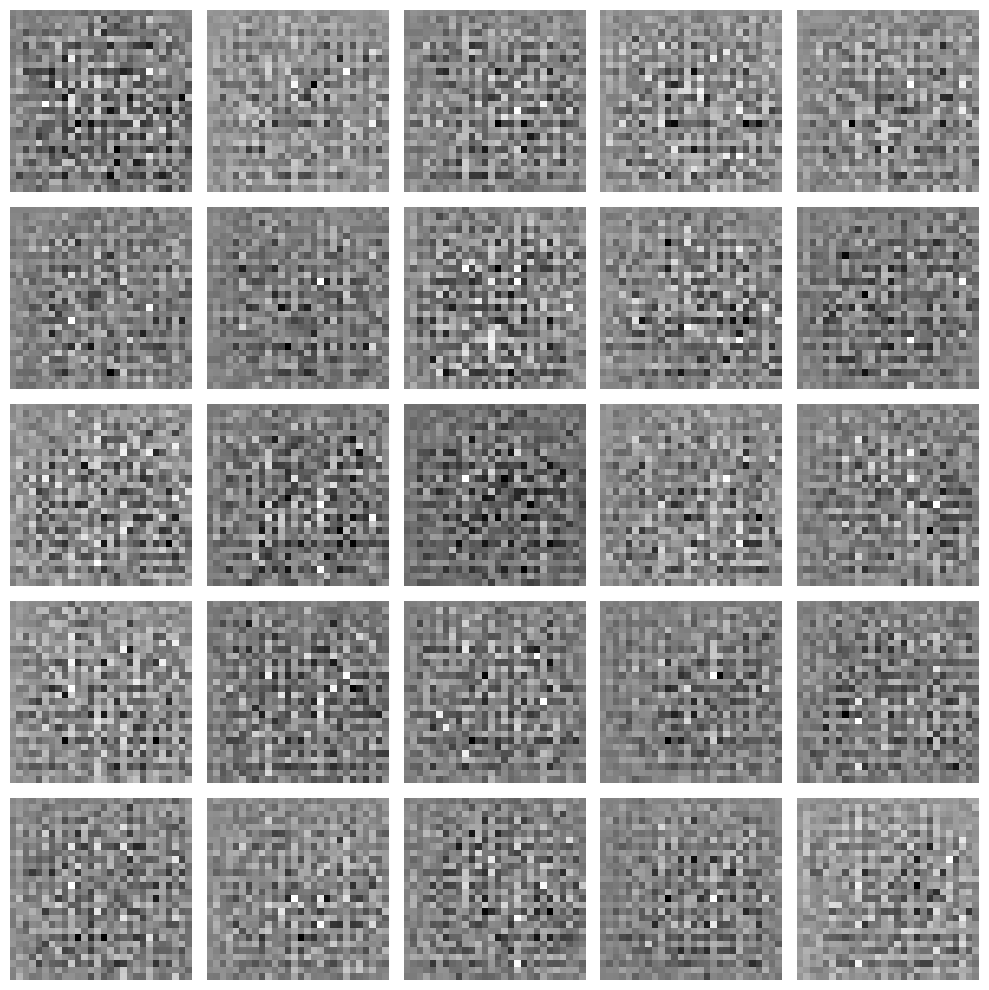

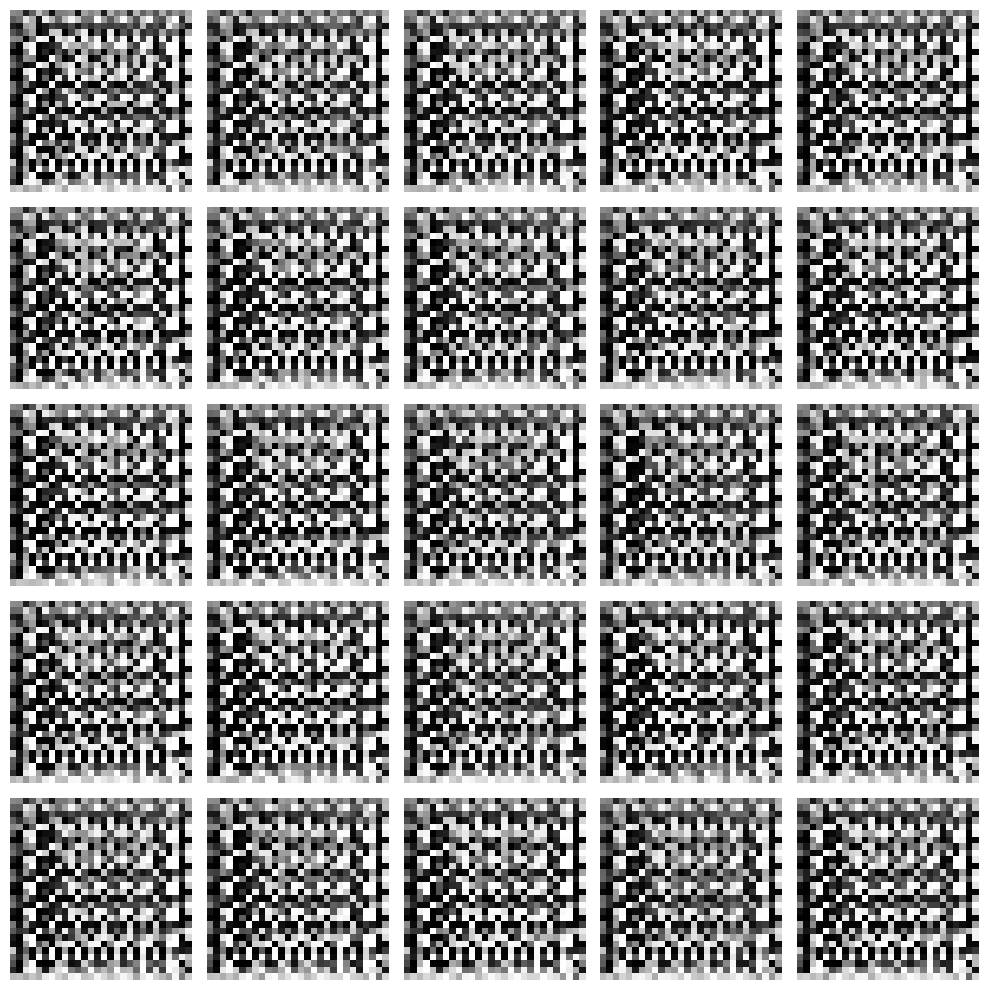

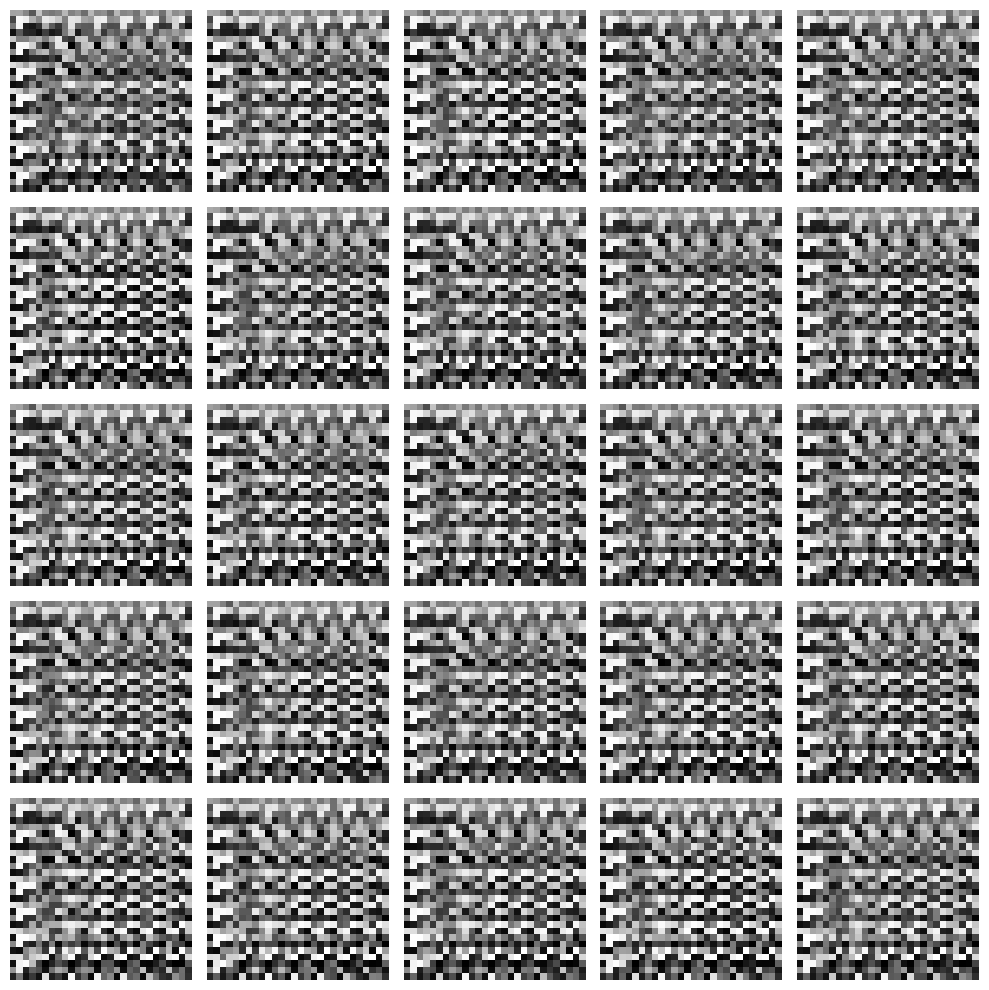

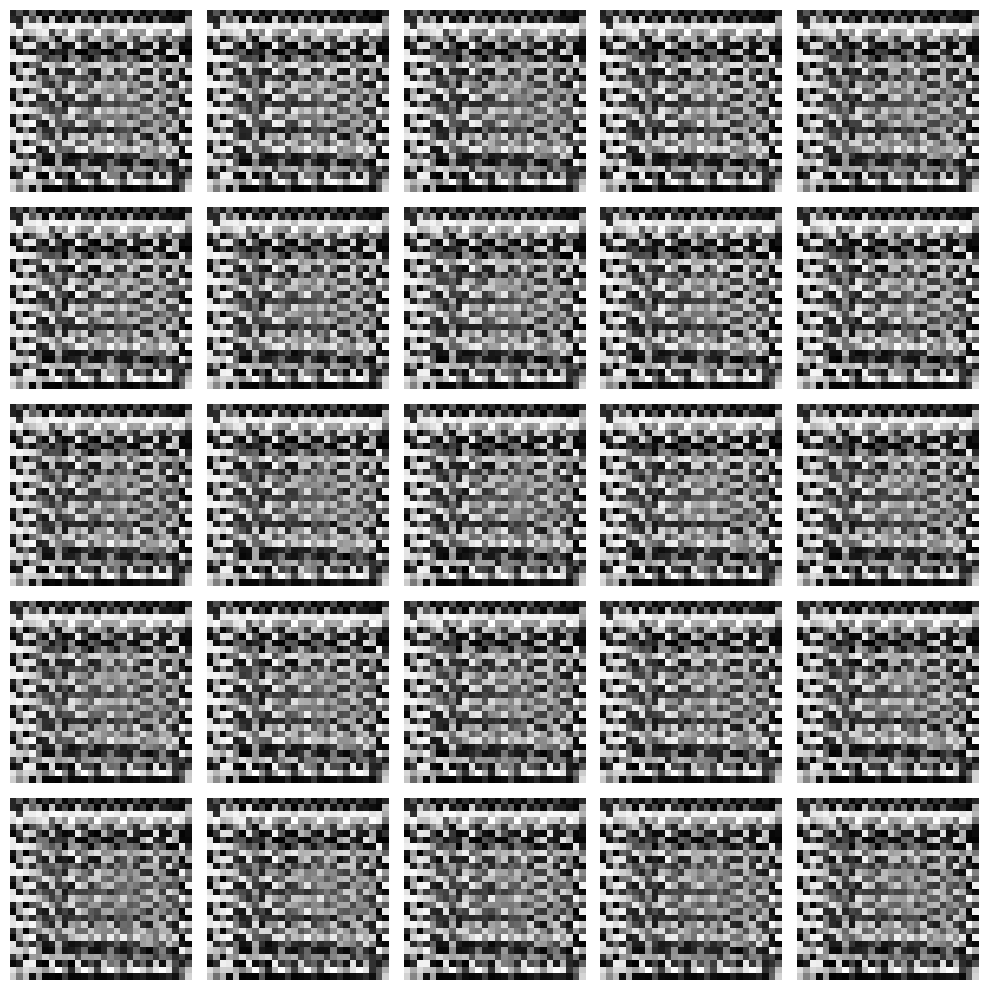

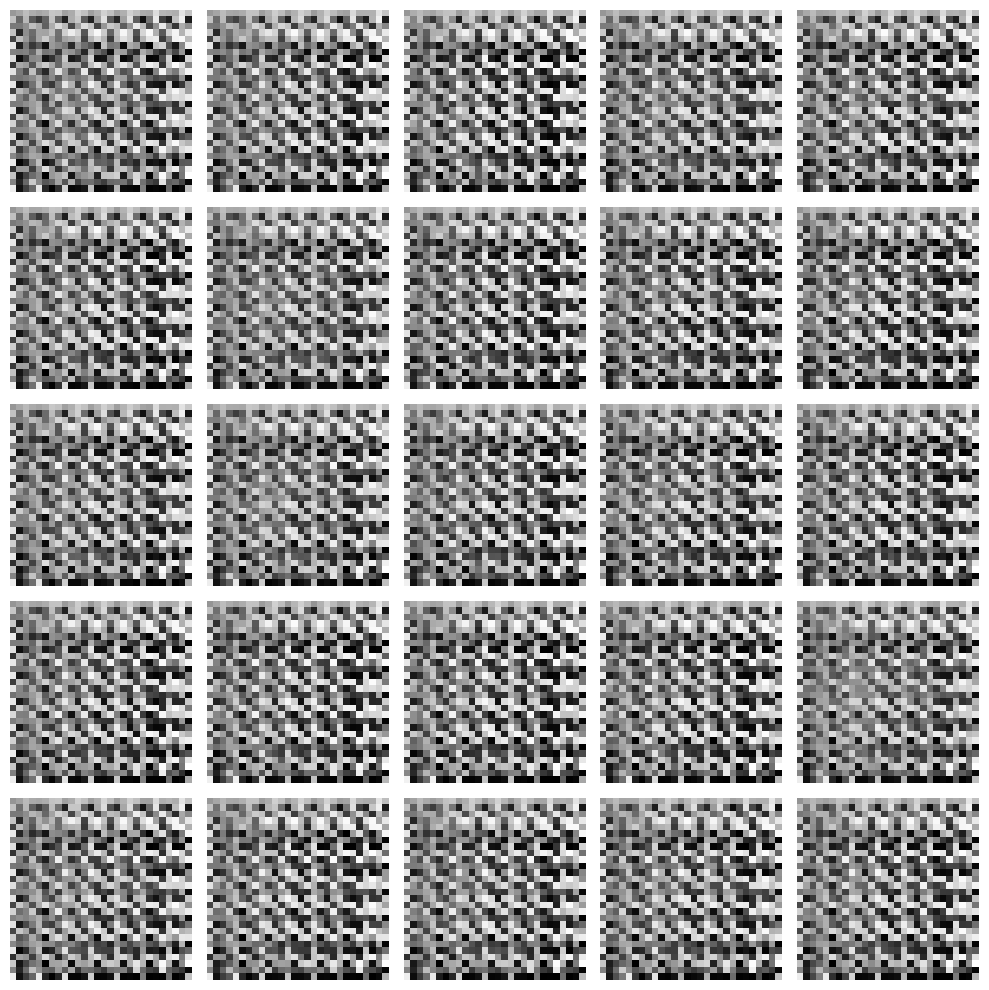

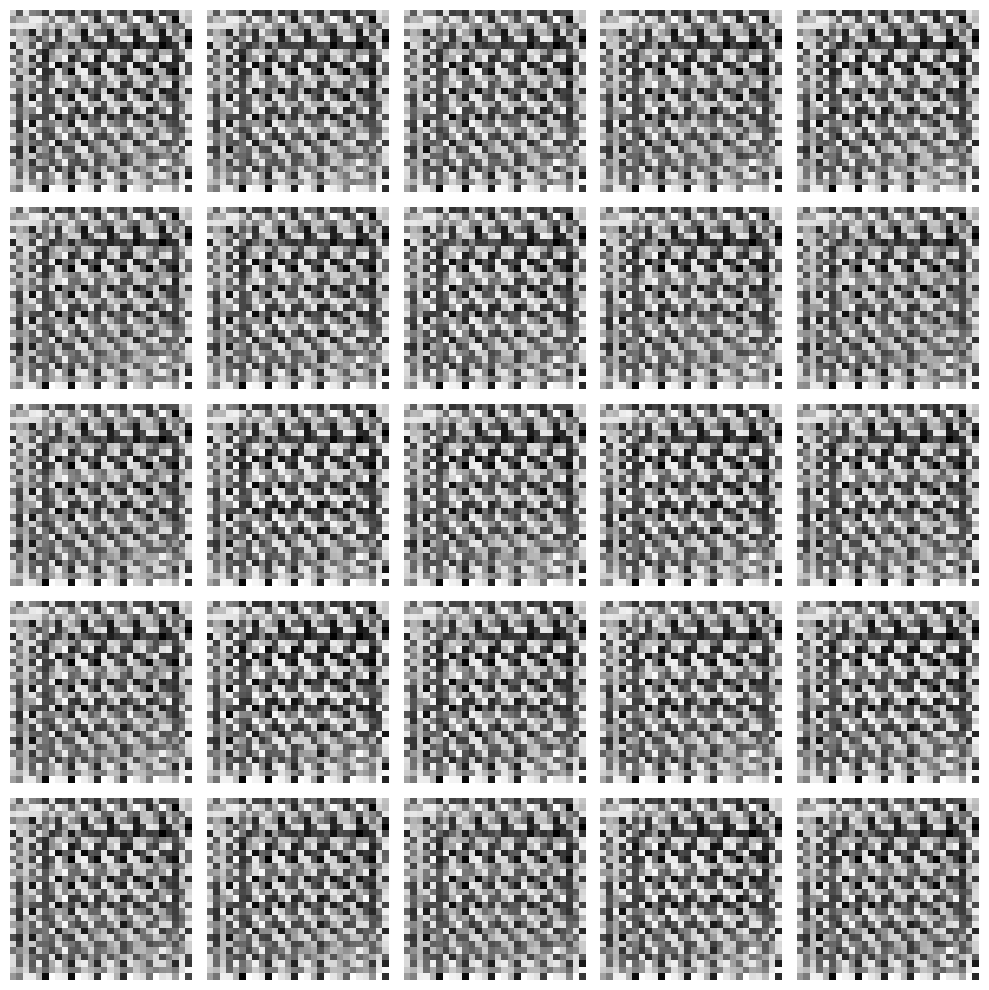

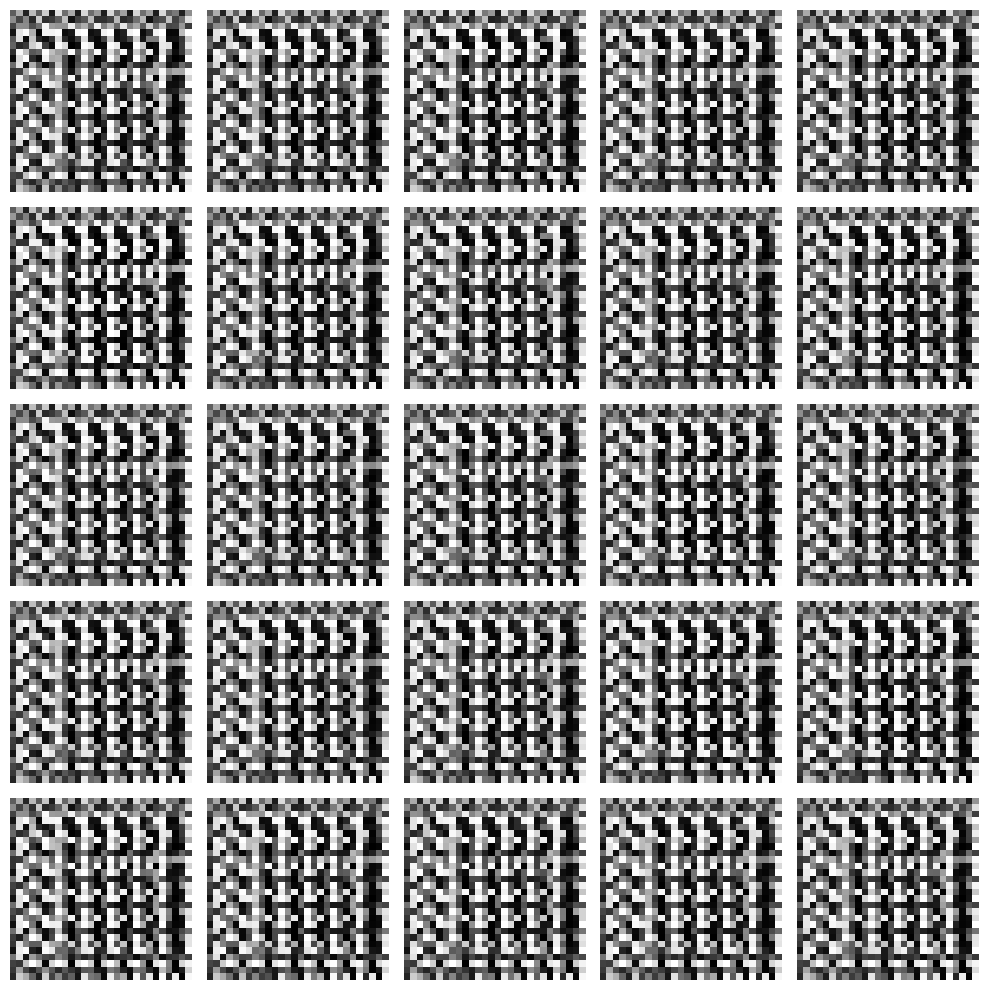

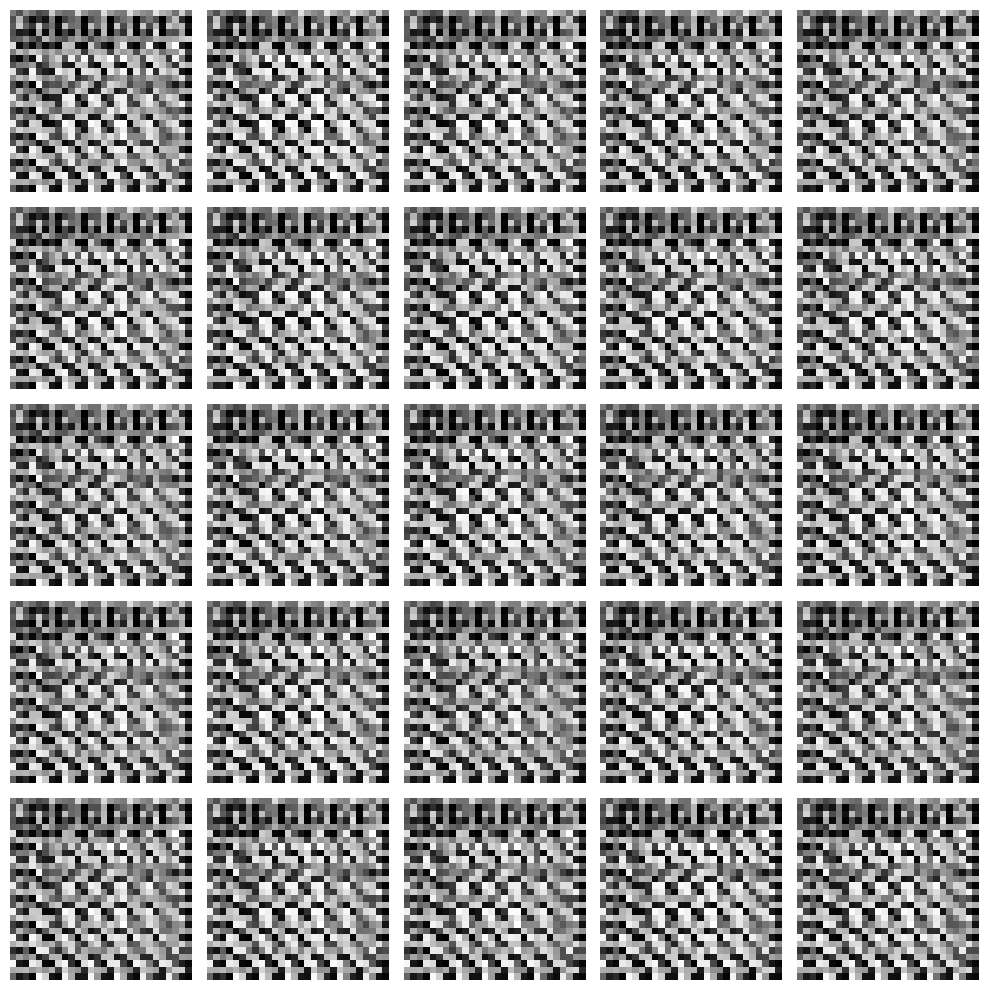

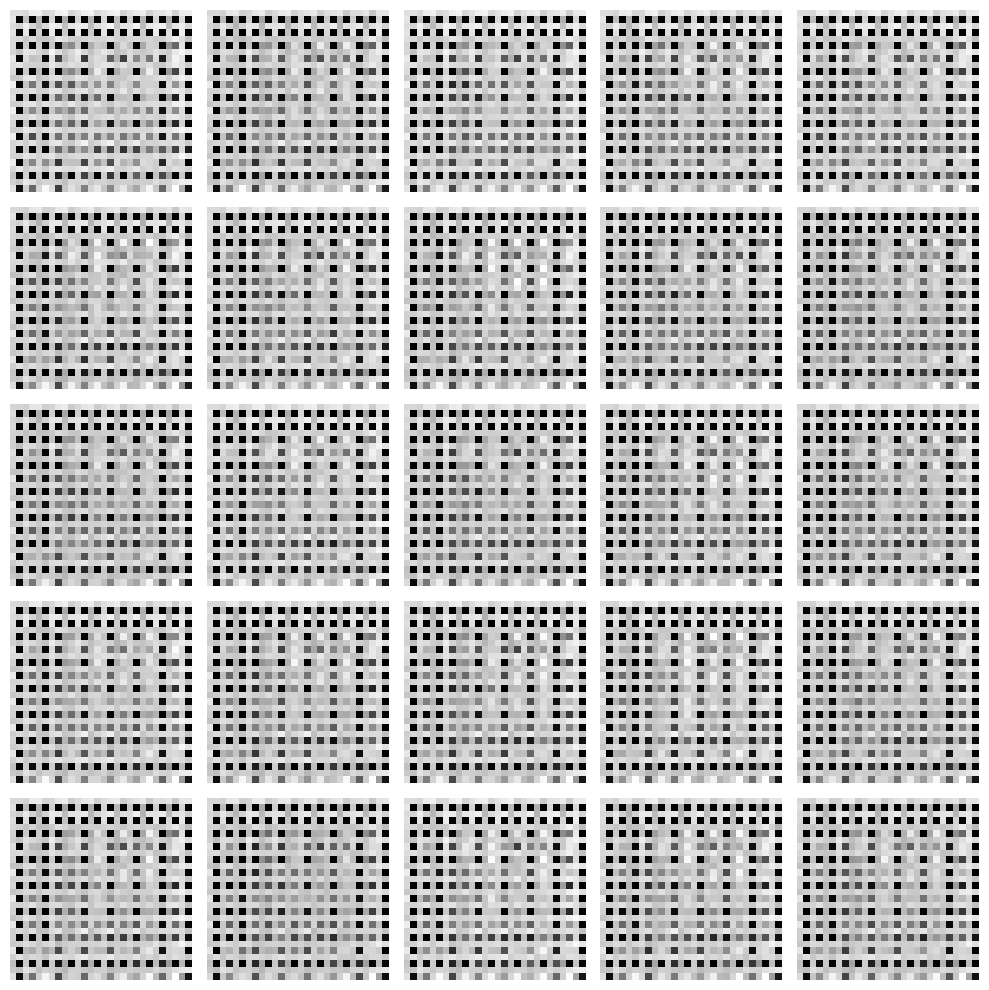

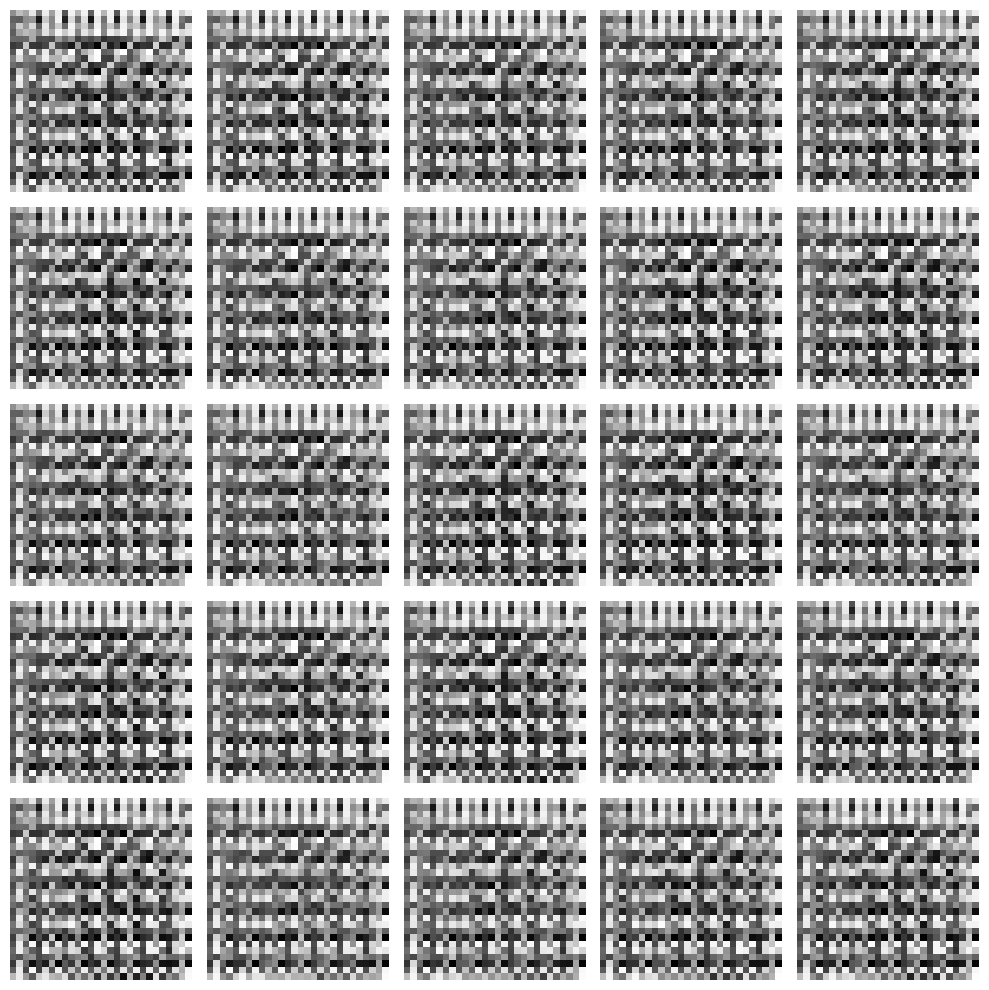

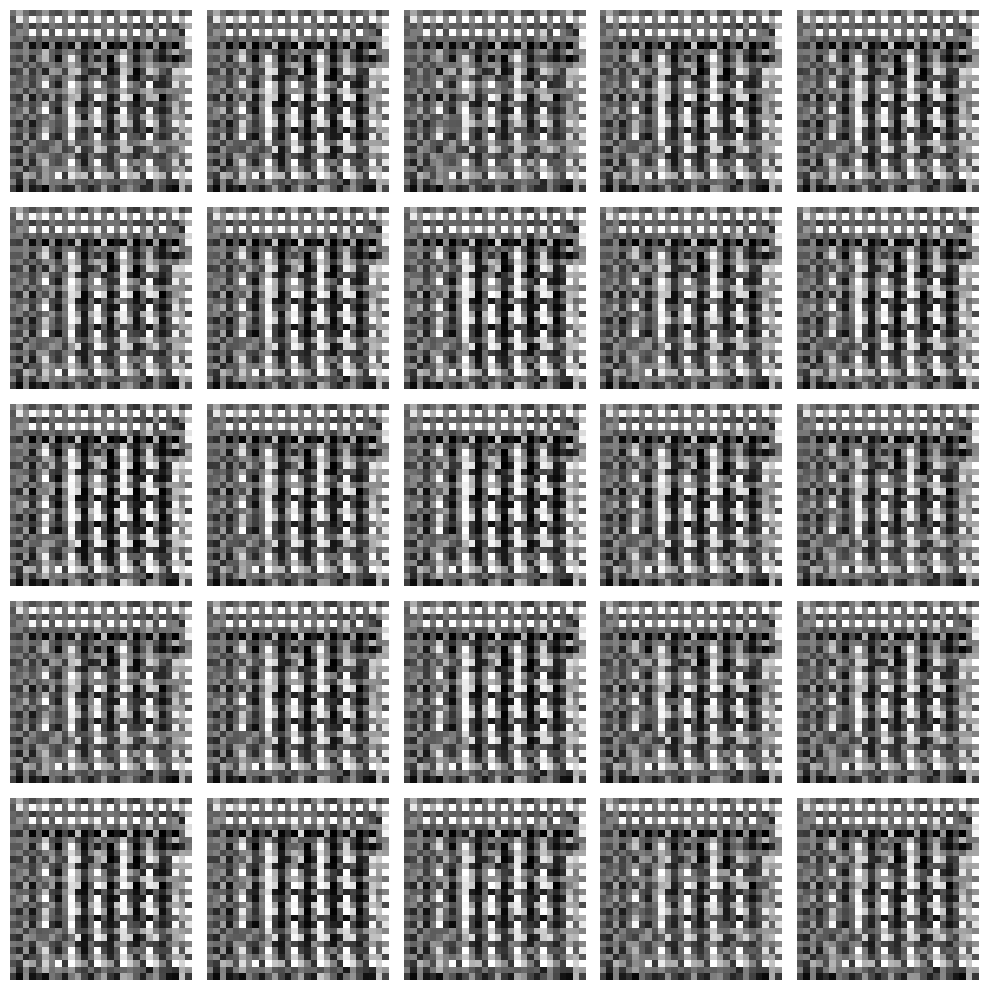

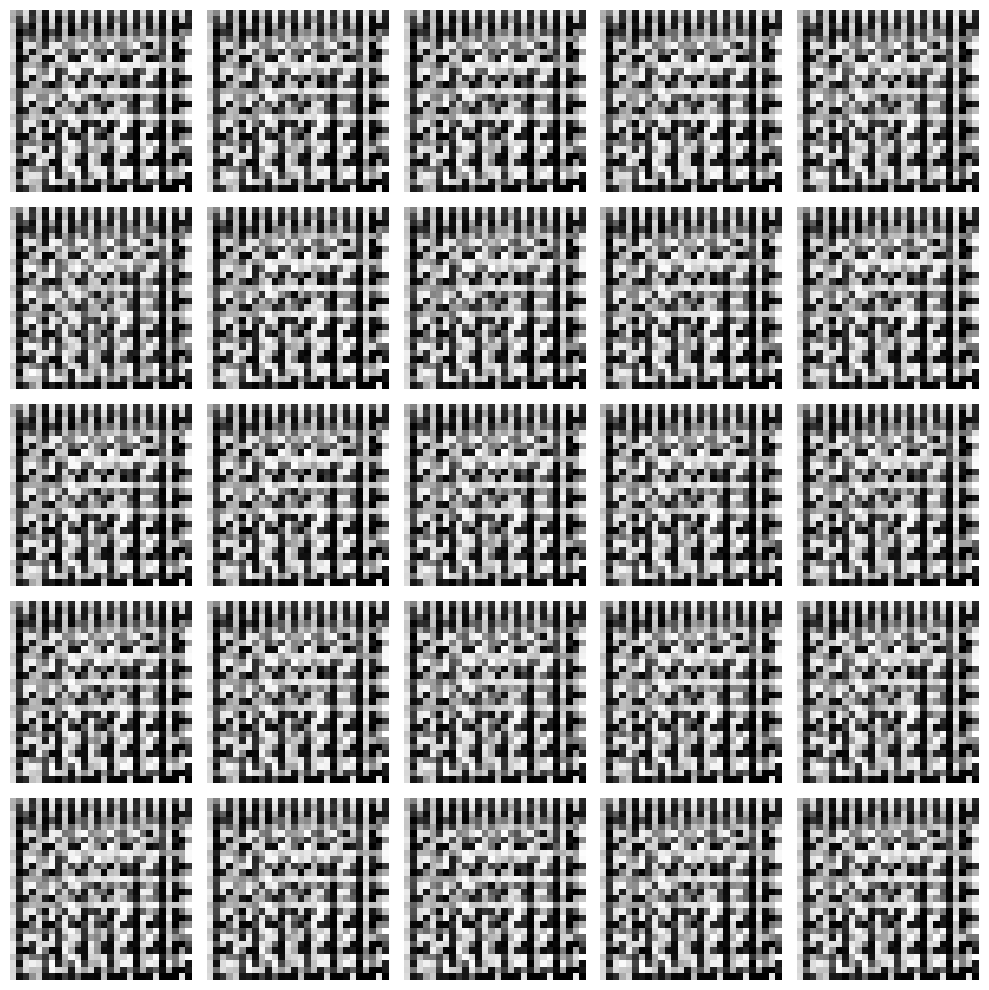

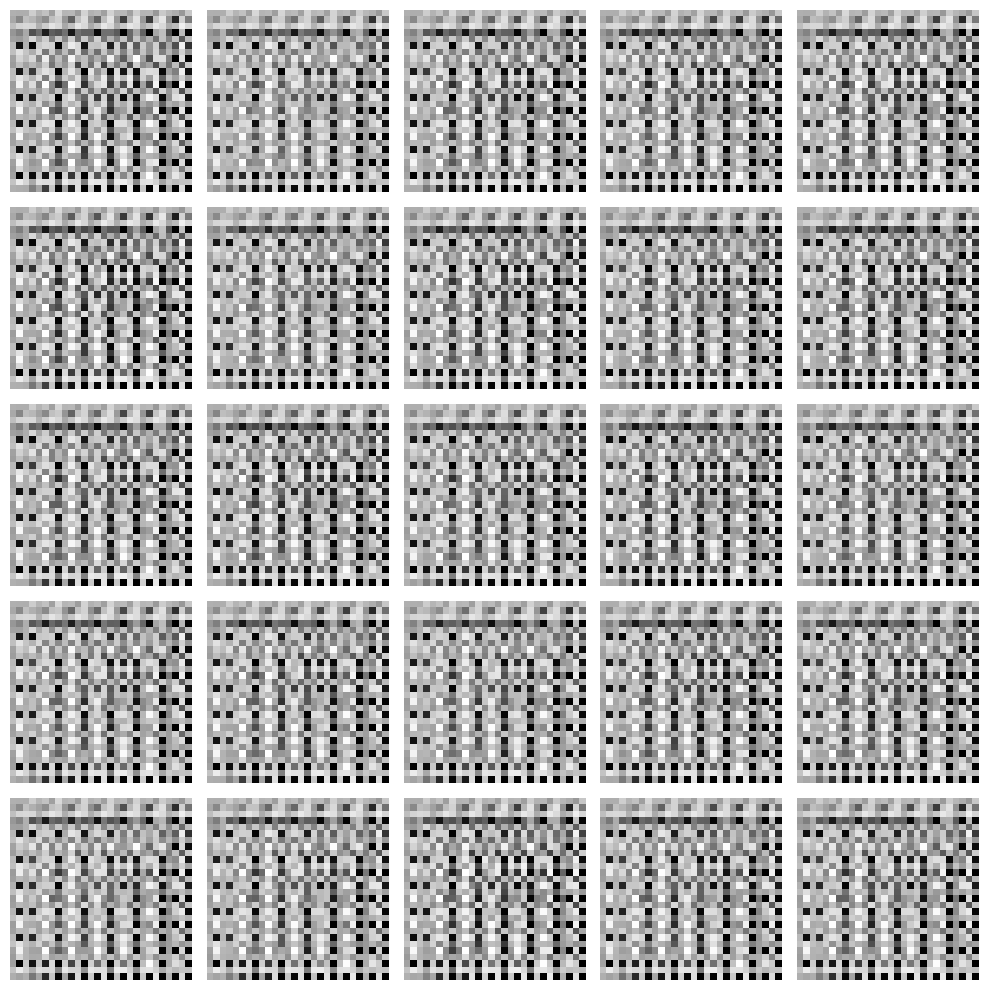

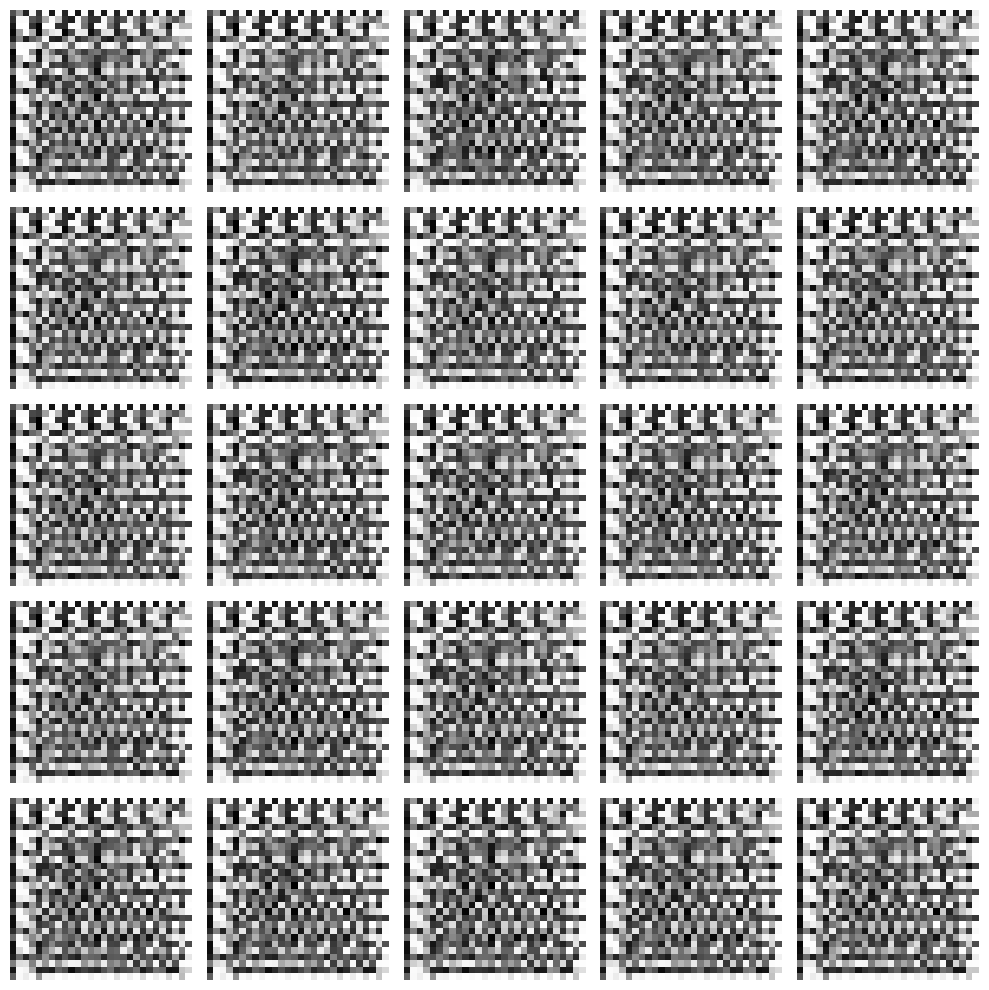

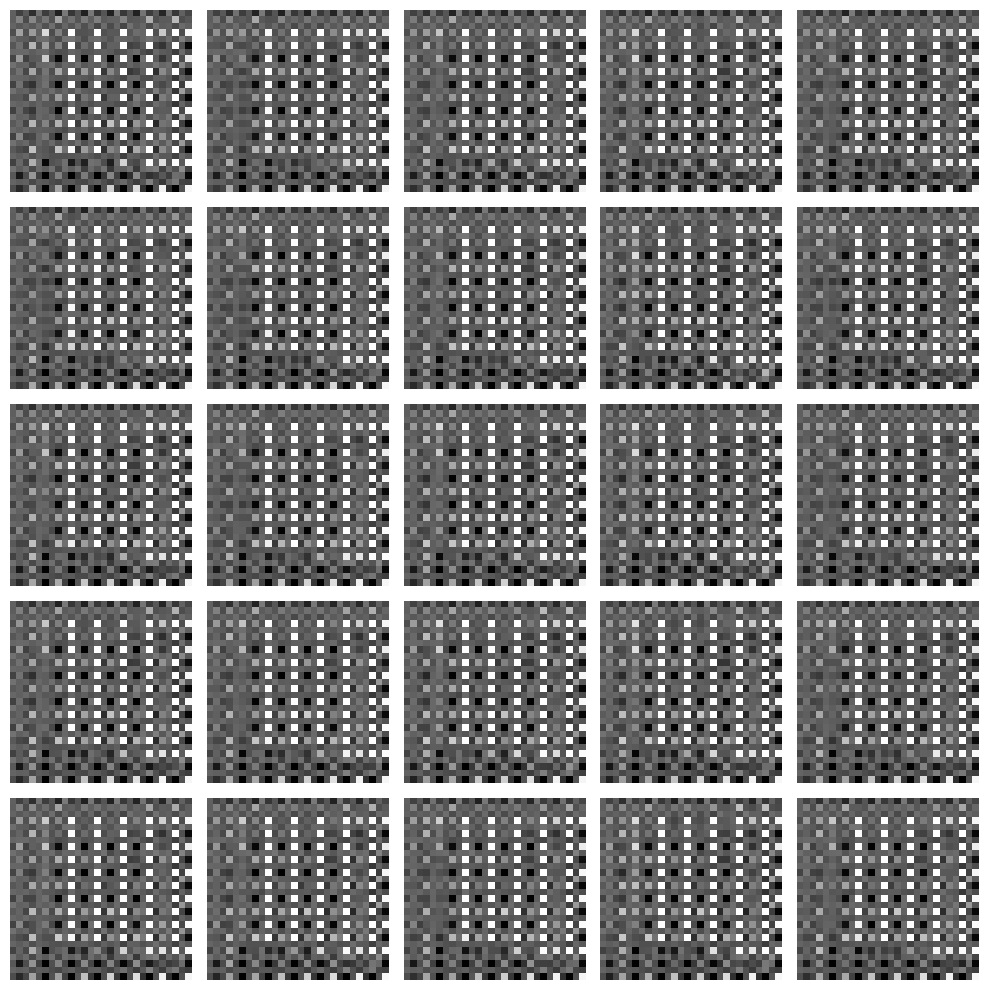

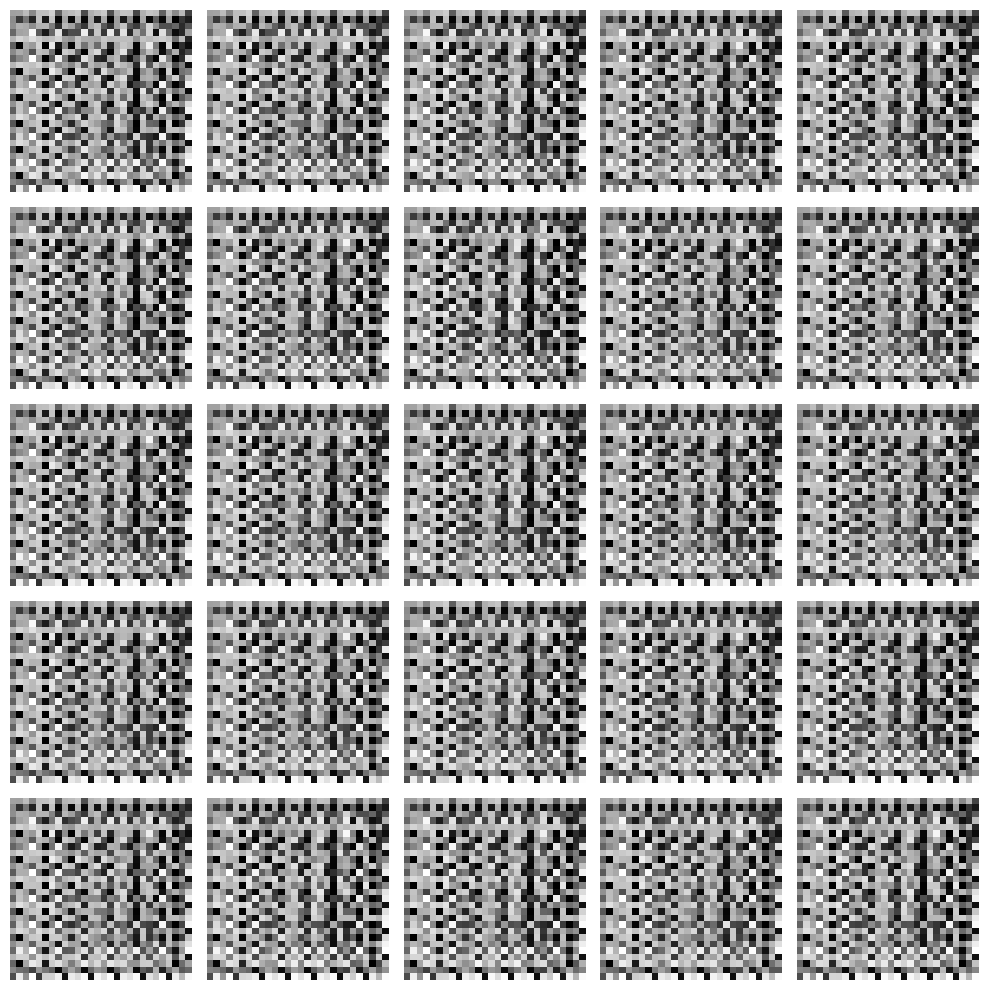

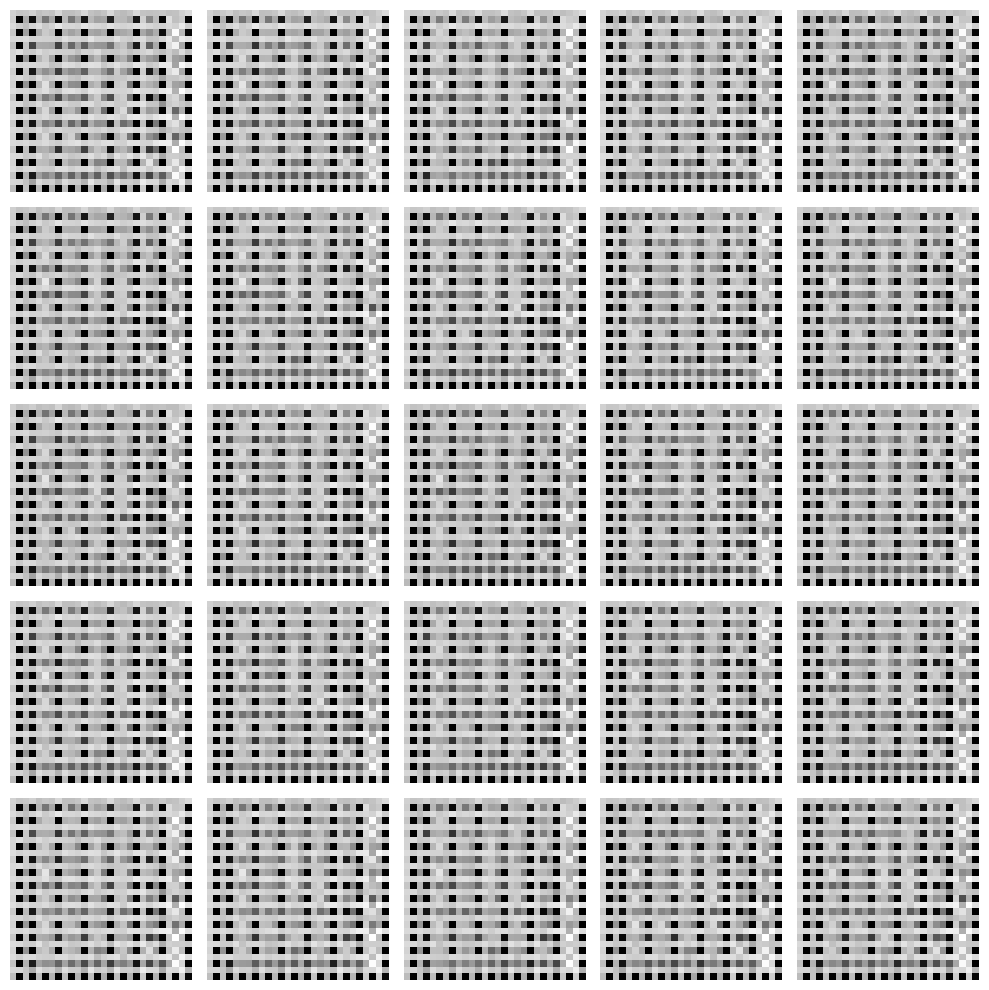

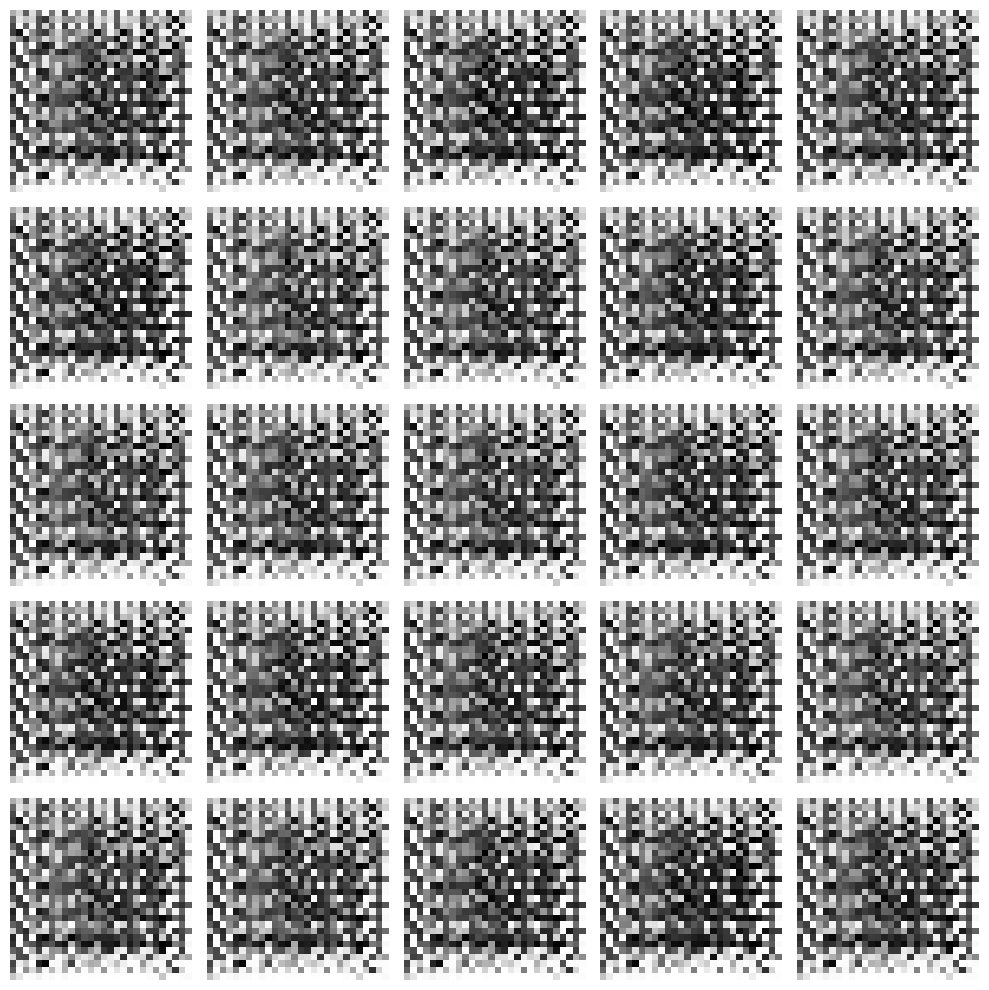

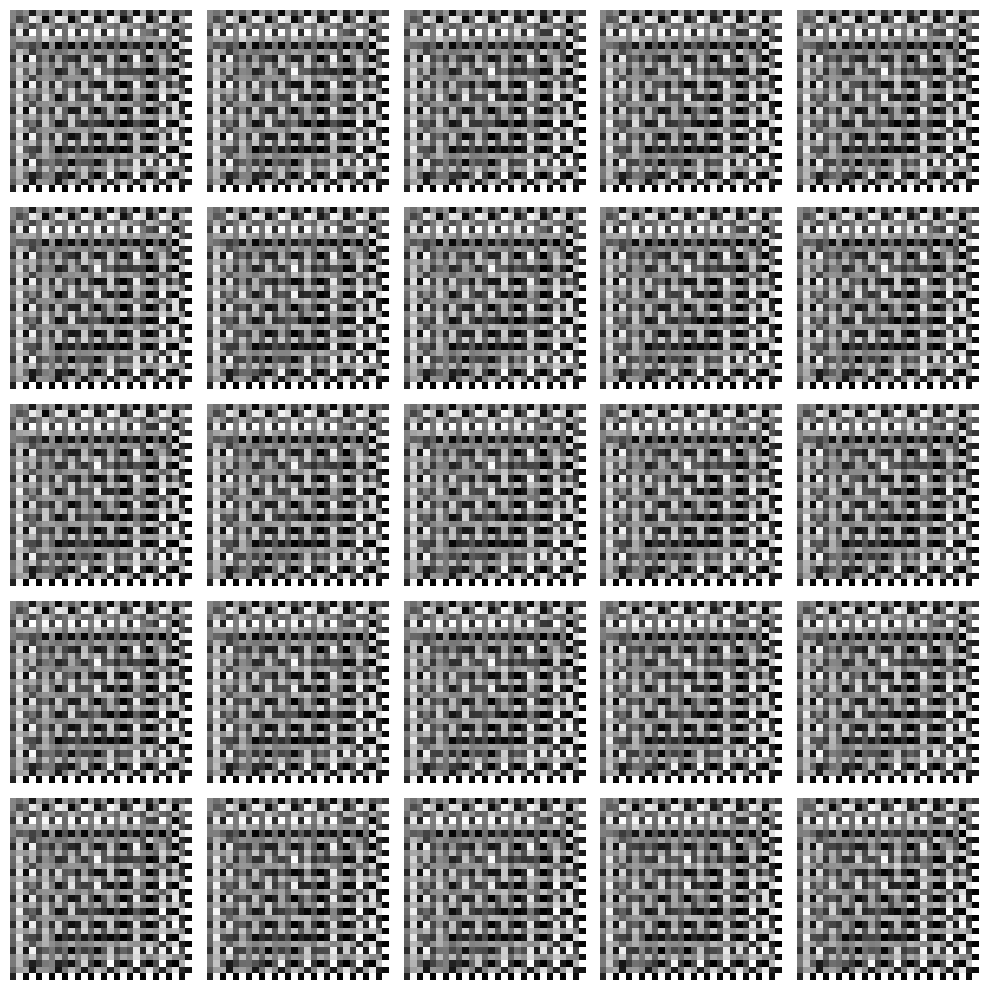

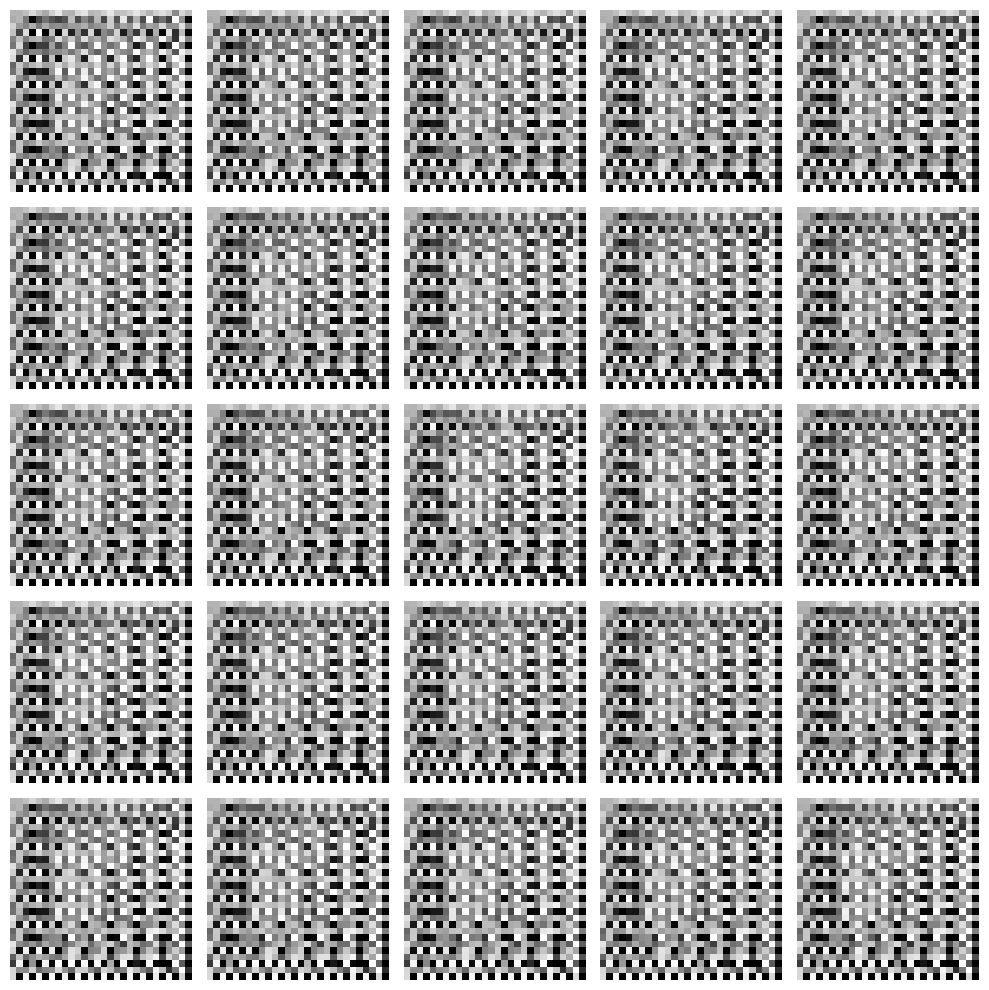

In [ ]:
# 학습 진행

gan_train(10000, 512, 500)